<h2> Bird Species Classification using Transfer Learing </h2>
<h3> CNN Architectures used in this classification: <h3>
        <li> Efficient Neural Network</li>
        <li> Residual Neural Network</li>
        <li> Inception Neural Network</li>
        <li> MobileNet</li>

In [108]:
import os
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Reshape, Activation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import classification_report
import sklearn

<h3> 1. Import training, validation and test datasets </h3> 

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dir = "Data/train"
valid_dir = "Data/valid"
test_dir = "Data/test"
train_dataset = image_dataset_from_directory(train_dir, 
                                            shuffle=True, 
                                            label_mode='int',
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            seed = 10)
validation_dataset = image_dataset_from_directory(valid_dir, 
                                                 shuffle = True,
                                                label_mode = 'int',
                                                 batch_size=BATCH_SIZE,
                                                 image_size = IMG_SIZE,
                                                 seed = 10)
test_dataset = image_dataset_from_directory(test_dir, 
                                           shuffle= False,
                                            batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE,
                                           seed =10)

Found 39364 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.


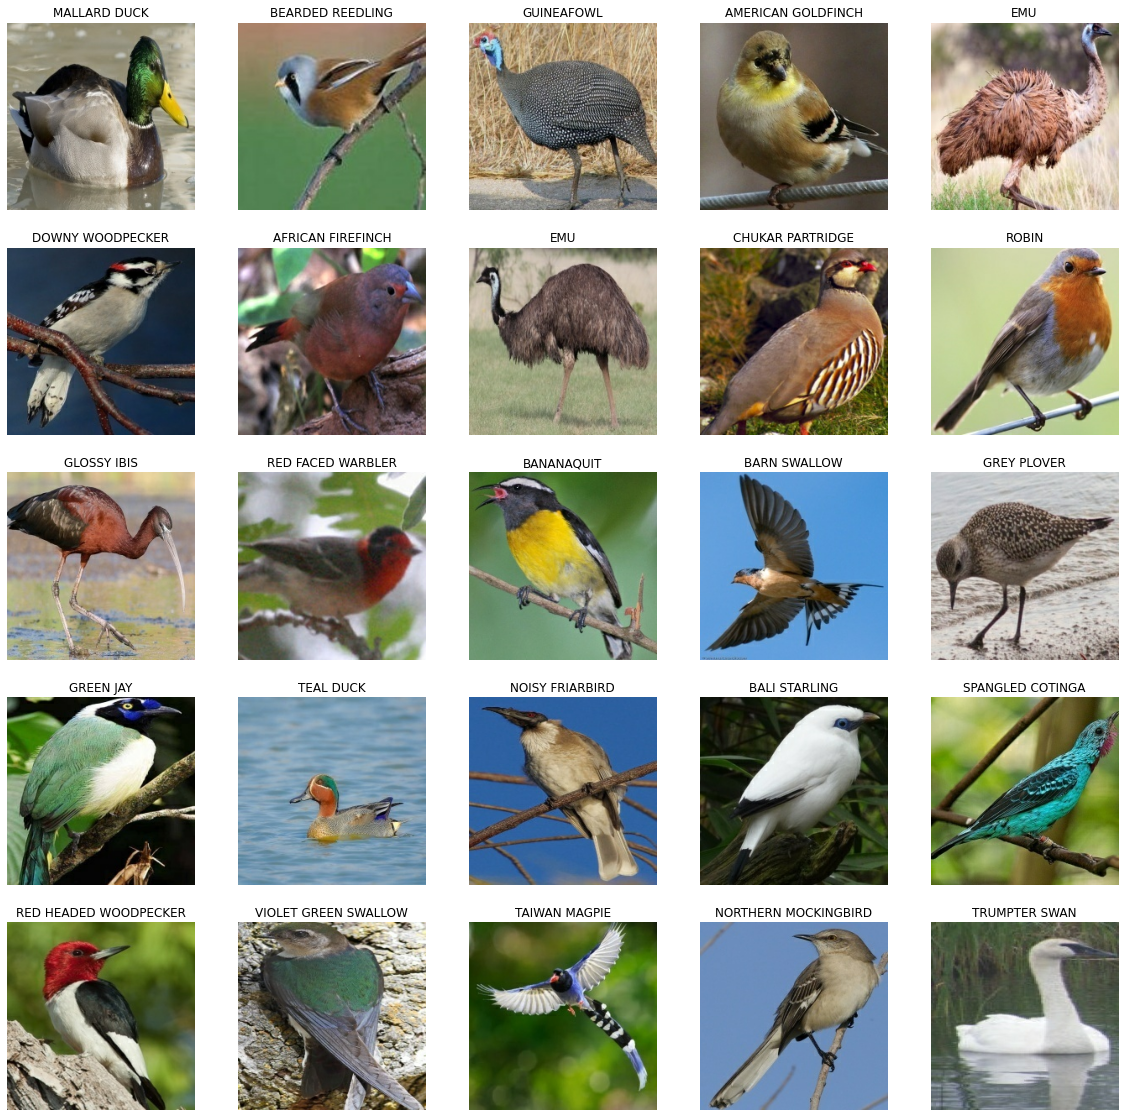

In [3]:
target_labels = train_dataset.class_names
n_classes = len(target_labels)
plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(target_labels[labels[i]])
        plt.axis('off')

<h3> 2. Preprocess and perform data augmentation on Training Dataset </h3>

In [4]:
# To prevent Memory bottlenecks add a preprocessing step
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset.prefetch(buffer_size=AUTOTUNE)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [5]:
def data_augumenter():
    data_augumentation = tf.keras.Sequential()
    data_augumentation.add(RandomFlip("horizontal"))
    data_augumentation.add(RandomRotation(0.2))
    return data_augumentation

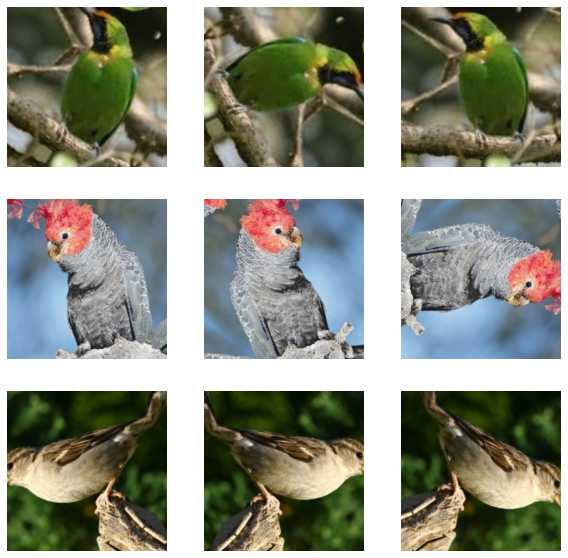

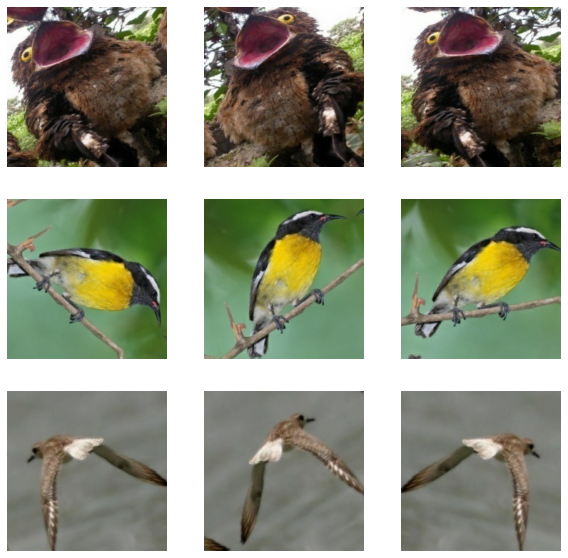

In [6]:
data_augumentation = data_augumenter()
for image, label in train_dataset.take(2):
    plt.figure(figsize= (10, 10))
    img = image[0]
    for i in range(9):
        if i%3 == 0:
            img = image[i]
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augumentation(tf.expand_dims(img, 0))
        plt.imshow(augmented_image[0].numpy().astype(np.uint8))
        plt.axis('off')

<h3> Creating a custom callback to check stopping at the end of every batch </h3> 

In [7]:
class BatchEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self,
                 monitor='val_loss',
                 min_delta=0,
                 patience=0,
                 verbose=0,
                 mode='auto',
                 baseline=None,
                 restore_best_weights=False):
        super(BatchEarlyStopping, self).__init__()

        self.monitor = monitor
        self.baseline = baseline
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.wait = 0
        self.stopped_batch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('BatchEarlyStopping mode %s is unknown, '
                          'fallback to auto mode.' % mode,
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_batch = 0
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_batch_end(self, batch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_batch = batch
                self.model.stop_training = True
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('\nRestoring model weights from the end of '
                              'the best batch')
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_batch > 0 and self.verbose > 0:
            print('Batch %05d: early stopping' % (self.stopped_batch + 1))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
        return monitor_value

In [8]:
def create_callbacks(root_dir, file_name, monitor = "val_loss", patience = 1, mode = 'min'):
    #Earlystopping callback
#     earlystopping_cb = BatchEarlyStopping(monitor= monitor,
#                                          patience= patience,
#                                          verbose = 1,
#                                          mode = mode,
#                                          restore_best_weights=True
#                                     )
    earlystopping_cb = EarlyStopping(monitor = monitor,
                                    patience = patience,
                                     verbose = 1,
                                     mode = mode,
                                     restore_best_weights = True
                                    )
    # Model CheckPoint CallBack
    checkpoint_file_path = os.path.join("Models", file_name)
    checkpoint_cb = ModelCheckpoint(filepath=checkpoint_file_path,
                                            save_best_only=True,
                                            monitor='accuracy',
                                            mode = 'max',
                                            verbose = 0,
                                            save_freq=50 #Save for every 50 batches
                                        ) 
    log_dir = root_dir + "\\logs\\fit\\" + datetime.now().strftime("%H-%M-%S")
    # Checkpoint for TensorBoard Visualization
    tensorboard_cb = TensorBoard(log_dir,
                            write_graph = True,
                            write_images = True,
                            update_freq = 'batch'
                        )
    #Learning rate Callback
    learningrate_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor = "loss")
    return [earlystopping_cb, checkpoint_cb, tensorboard_cb, learningrate_cb]

<h3>Transfer Learning Using EfficientNet Architecture</h3>

In [9]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_effnet

In [10]:
def EfficientNet():
    IMG_SHAPE = IMG_SIZE + (3, )
    effnet_model = EfficientNetB1(input_shape=IMG_SHAPE,
                               include_top=False
                            )
    effnet_model.trainable = True
    inputs = tf.keras.Input(shape=IMG_SHAPE, name = "Input_layer")
    x = data_augumentation(inputs)
    x = preprocess_input_effnet(x)
    x = effnet_model(x)
    x = GlobalAveragePooling2D(name = "pooling_layer")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = Dense(n_classes, activation = 'softmax', name = "Output_layer")
    outputs = prediction_layer(x)
    model = Model(inputs, outputs)
    return model

In [11]:
EfficientNet().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 275)               352275    
Total params: 6,927,514
Trainable params: 6,865,459
Non-trainable params: 62,055
______________________________________________

In [12]:
effnet_model = EfficientNet()
loss_function = sparse_categorical_crossentropy
optimizer = Adam(learning_rate=0.001)
effnet_model.compile(optimizer = optimizer,
                    loss=loss_function,
                    metrics= ['accuracy'])
callbacks = create_callbacks("Efficient_Net_model", "EfficientNet.hdf5", monitor='val_loss', patience=1, mode = 'min')

In [13]:
Efficient_Net_history = effnet_model.fit(train_dataset,
                                validation_data=validation_dataset,
                                batch_size=BATCH_SIZE,
                                epochs = 10,
                                use_multiprocessing=True,
                                verbose = 1,
                                callbacks=callbacks)

C:\Users\Hemanth\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/10
1231/1231 [==============================] - 7691s 6s/step - loss: 1.1523 - accuracy: 0.7336 - val_loss: 0.2538 - val_accuracy: 0.9258
Epoch 2/10
1231/1231 [==============================] - 7640s 6s/step - loss: 0.3980 - accuracy: 0.8921 - val_loss: 0.1968 - val_accuracy: 0.9382
Epoch 3/10
1231/1231 [==============================] - 7666s 6s/step - loss: 0.3044 - accuracy: 0.9153 - val_loss: 0.1417 - val_accuracy: 0.9578
Epoch 4/10
1231/1231 [==============================] - 7660s 6s/step - loss: 0.2584 - accuracy: 0.9263 - val_loss: 0.1936 - val_accuracy: 0.9462
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


<h3> Tranfer Learning using Resnet50 Architecture </h3>

In [14]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
preprocess_input_resnet = tf.keras.applications.resnet_v2.preprocess_input

In [15]:
def resnet():
    IMG_SHAPE = IMG_SIZE + (3, )
    resnet_model = ResNet50V2(weights='imagenet', 
                              include_top = False, 
                             input_shape=IMG_SHAPE)
    resnet_model.trainable = True
    #Fine Tuning
    fine_tune_at = 180
#   Freeze initial layers of resnet model
    for layer in resnet_model.layers[:fine_tune_at]:
        layer.trainable = False
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augumentation(inputs)
    x = preprocess_input_resnet(x)
    x = resnet_model(x)
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = Dense(n_classes, activation = 'softmax')
    outputs = prediction_layer(x)
    model = Model(inputs, outputs)
    return model

In [16]:
resnet().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0   

In [17]:
resnet_model = resnet()
loss_function = sparse_categorical_crossentropy
optimizer = Adam(learning_rate=1e-3)
resnet_model.compile(optimizer = optimizer,
                    loss=loss_function,
                    metrics= ['accuracy'])
callbacks = create_callbacks("ResNet50_model", "ResNet50model.hdf5", monitor='val_loss', patience=1, mode = 'min')

In [18]:
resnet_history = resnet_model.fit(train_dataset,
                                validation_data=validation_dataset,
                                batch_size=BATCH_SIZE,
                                epochs = 10,
                                use_multiprocessing=True,
                                verbose = 1,
                                callbacks=callbacks)

Epoch 1/10
1231/1231 [==============================] - 2829s 2s/step - loss: 1.3940 - accuracy: 0.6694 - val_loss: 0.3028 - val_accuracy: 0.9164
Epoch 2/10
1231/1231 [==============================] - 2786s 2s/step - loss: 0.6047 - accuracy: 0.8348 - val_loss: 0.2516 - val_accuracy: 0.9258
Epoch 3/10
1231/1231 [==============================] - 2988s 2s/step - loss: 0.4690 - accuracy: 0.8662 - val_loss: 0.2116 - val_accuracy: 0.9375
Epoch 4/10
1231/1231 [==============================] - 2917s 2s/step - loss: 0.3881 - accuracy: 0.8889 - val_loss: 0.1814 - val_accuracy: 0.9462
Epoch 5/10
1231/1231 [==============================] - 3023s 2s/step - loss: 0.3370 - accuracy: 0.9028 - val_loss: 0.1911 - val_accuracy: 0.9404
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


<h3> Tranfer Learning using MobileNetV2 Architecture </h3>

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobinet

In [20]:
def mobinet():
    IMG_SHAPE = IMG_SIZE + (3, )
    mobinet_model = MobileNetV2(input_shape=IMG_SHAPE,
                               include_top=False,
                               weights='imagenet',
                            )
    mobinet_model.trainable = False
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augumentation(inputs)
    x = preprocess_input_mobinet(x)
    x = mobinet_model(x)
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = Dense(n_classes, activation = 'softmax')
    outputs = prediction_layer(x)
    model = Model(inputs, outputs)
    return model

In [21]:
mobinet().summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0   

In [23]:
mobinet_model = mobinet()
loss_function = sparse_categorical_crossentropy
optimizer = Adam(learning_rate=1e-3)
mobinet_model.compile(optimizer = optimizer,
                    loss=loss_function,
                    metrics= ['accuracy'])
callbacks = create_callbacks("MobileNetV2_model", "MobileNetmodel.hdf5", monitor = "val_loss", patience=1, mode = "min")

In [24]:
mobinet_history = mobinet_model.fit(train_dataset,
                                validation_data=validation_dataset,
                                batch_size=BATCH_SIZE,
                                epochs = 5,
                                use_multiprocessing=True,
                                verbose = 1,
                                callbacks=callbacks)

Epoch 1/5
1231/1231 [==============================] - 899s 727ms/step - loss: 1.5692 - accuracy: 0.6537 - val_loss: 0.4363 - val_accuracy: 0.9055
Epoch 2/5
1231/1231 [==============================] - 868s 705ms/step - loss: 0.7021 - accuracy: 0.8182 - val_loss: 0.3122 - val_accuracy: 0.9156
Epoch 3/5
1231/1231 [==============================] - 868s 705ms/step - loss: 0.5692 - accuracy: 0.8464 - val_loss: 0.2675 - val_accuracy: 0.9280
Epoch 4/5
1231/1231 [==============================] - 862s 700ms/step - loss: 0.5126 - accuracy: 0.8583 - val_loss: 0.2379 - val_accuracy: 0.9345
Epoch 5/5
1231/1231 [==============================] - 865s 702ms/step - loss: 0.4655 - accuracy: 0.8701 - val_loss: 0.2179 - val_accuracy: 0.9367


<h3> Tranfer Learning using InceptionV3 Architecture </h3> 

In [25]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_Inception

In [26]:
def inception():
    IMG_SHAPE = IMG_SIZE + (3, )
    inception_model = InceptionV3(input_shape=IMG_SHAPE,
                               include_top=False,
                               weights='imagenet',
                            )
    inception_model.trainable = True
#     print(len(inception_model.layers))
    fine_tune_at = 280
#   Freeze initial layers of base model
    for layer in inception_model.layers[:fine_tune_at]:
        layer.trainable = False
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augumentation(inputs)
    x = preprocess_input_Inception(x)
    x = inception_model(x)
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = Dense(n_classes, activation = 'softmax')
    outputs = prediction_layer(x)
    model = Model(inputs, outputs)
    return model

In [27]:
inception_model = inception()
# inception_model.summary()
loss_function = sparse_categorical_crossentropy
optimizer = Adam(learning_rate=1e-3)
inception_model.compile(optimizer = optimizer,
                    loss=loss_function,
                    metrics= ['accuracy'])
callbacks = create_callbacks("InceptionV3_model", "Inceptionmodel.hdf5", monitor="val_loss", patience=1, mode = "min")

In [28]:
inception_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0   

In [29]:
inception_history = inception_model.fit(train_dataset,
                                validation_data=validation_dataset,
                                batch_size=BATCH_SIZE,
                                epochs = 5,
                                use_multiprocessing=True,
                                verbose = 1,
                                callbacks=callbacks)

Epoch 1/5
1231/1231 [==============================] - 2158s 2s/step - loss: 1.2576 - accuracy: 0.6941 - val_loss: 0.2919 - val_accuracy: 0.9098
Epoch 2/5
1231/1231 [==============================] - 2147s 2s/step - loss: 0.5591 - accuracy: 0.8438 - val_loss: 0.2598 - val_accuracy: 0.9207
Epoch 3/5
1231/1231 [==============================] - 2156s 2s/step - loss: 0.4326 - accuracy: 0.8772 - val_loss: 0.2120 - val_accuracy: 0.9498
Epoch 4/5
1231/1231 [==============================] - 2223s 2s/step - loss: 0.3546 - accuracy: 0.8978 - val_loss: 0.2093 - val_accuracy: 0.9396
Epoch 5/5
1231/1231 [==============================] - 2088s 2s/step - loss: 0.3153 - accuracy: 0.9095 - val_loss: 0.1794 - val_accuracy: 0.9433


<h3>Create Custom Functions to evaluate different model performance </h3>

In [30]:
y_true = np.hstack([y for _, y in test_dataset])

In [31]:
def print_metrics(model):
    val_score = model.evaluate(validation_dataset, verbose = 1)
    test_score = model.evaluate(test_dataset, verbose = 1)
    print(f"""
Validation loss : {val_score[0]:.4f}
Accuarcy on validation set is : {val_score[1]*100:.2f} % 
""")
    print(f"""
Test loss : {test_score[0]:.4f}
Accuarcy on test set is : {test_score[1]*100:.2f} % 
""")

In [32]:
def get_report(y_pred):
    report = classification_report(y_true, y_pred, target_names = target_labels, output_dict = True)
    return report

In [33]:
def get_f1_scores(report):
    class_f1_scores = {}
    for key, value in report.items():
        if key == 'accuracy':
            break
        class_f1_scores[key] = value['f1-score']
    report_df = pd.DataFrame(class_f1_scores, index = ['f1-score']).T
    report_df.sort_values('f1-score', axis = 0, inplace = True)
    return report_df

In [34]:
def plot_f1_scores(report_df, model_name = ""):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(range(30), report_df[:30]["f1-score"].values)
    ax.set_yticks(range(30))
    ax.set_yticklabels(list(report_df.index[:30]))
    ax.set_ylabel("Bird Species")
    ax.set_xlabel("F1-Scores")
    ax.set_title(f"F1 Scores for Different Species ({model_name})")
    plt.show()

In [76]:
def load_and_prep(file_name, shape=224, scale=False):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, size=([shape, shape]))
    if scale:
        image = image/255.
    return image

In [82]:
def pred_custom_images(root_dir, model):
    custom_images = [root_dir + img_path for img_path in os.listdir(root_dir)]
    fig, ax = plt.subplots(3, 2, figsize = (15, 15))
    i = 0
    for img in custom_images[:3]:
        img = load_and_prep(img)
        pred_prob = model.predict(tf.expand_dims(img, axis = 0))
        pred_class = target_labels[pred_prob.argmax()]
        top_5_i = (pred_prob.argsort())[0][-5:][::-1]
        values = pred_prob[0][top_5_i]
        labels = []
        for x in range(5):
            labels.append(target_labels[top_5_i[x]])

        ax[i][0].imshow(img/255.) 
        ax[i][0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
        ax[i][0].axis(False)

        # Plotting Models Top 5 Predictions
        ax[i][1].barh(labels, values, color = 'orange')
        ax[i][1].set_title('Top 5 Predictions')
        i=i+1

<h3>** Evaluating Efficient Net Model Perfomance **</h3>

In [35]:
best_effnet_model = tf.keras.models.load_model("Models/EfficientNet.hdf5")

In [36]:
print_metrics(best_effnet_model)

43/43 [==============================] - 60s 1s/step - loss: 0.1373 - accuracy: 0.9556

Validation loss : 0.1465
Accuarcy on validation set is : 95.05 % 


Test loss : 0.1373
Accuarcy on test set is : 95.56 % 



In [39]:
effnet_pred = best_effnet_model.predict(test_dataset, verbose = 1)
effnet_pred = effnet_pred.argmax(axis = 1)
report = get_report(effnet_pred)

43/43 [==============================] - 59s 1s/step


In [40]:
report_df = get_f1_scores(report)
pd.concat([report_df.head(10), report_df.tail(3)],axis = 0)

f1-score
GILDED FLICKER           0.285714
TAKAHE                   0.500000
NORTHERN CARDINAL        0.571429
CINNAMON TEAL            0.571429
PURPLE SWAMPHEN          0.600000
CRESTED NUTHATCH         0.666667
BEARDED REEDLING         0.666667
NORTHERN FLICKER         0.714286
PELICAN                  0.750000
NOISY FRIARBIRD          0.750000
GREEN MAGPIE             1.000000
GILA WOODPECKER          1.000000
YELLOW HEADED BLACKBIRD  1.000000

<h4> Efficient Net model has low prediction accuracy on: </h4>
    <li> GILDED FLICKER </li>
    <li> TAKAHE</li>
    <li>NORTHERN CARDINAL </li>  
     <li> CINNAMON TEAL</li>

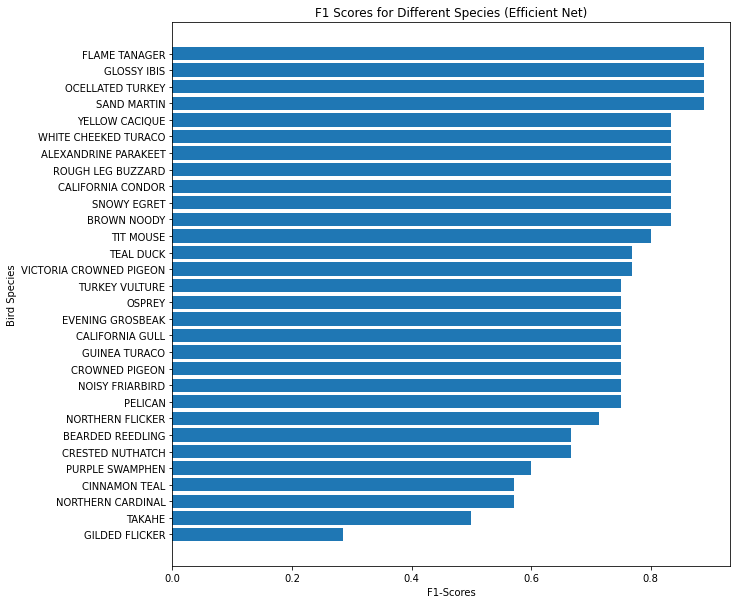

In [41]:
plot_f1_scores(report_df, model_name = "Efficient Net")

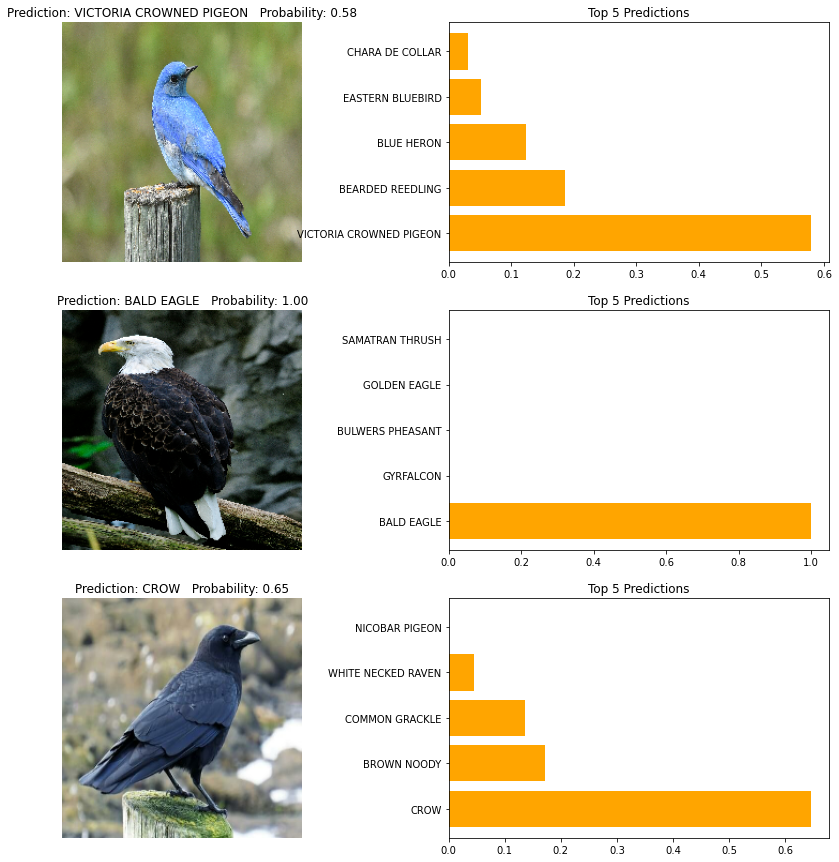

In [90]:
pred_custom_images("Example Images/", best_effnet_model)

<h3> **Evaluating Mobinet Model Performance ** </h3>

In [42]:
best_mobinet_model = tf.keras.models.load_model("Models/MobileNetmodel.hdf5")

In [43]:
print_metrics(best_mobinet_model)

43/43 [==============================] - 26s 603ms/step - loss: 0.1795 - accuracy: 0.9513

Validation loss : 0.2306
Accuarcy on validation set is : 93.09 % 


Test loss : 0.1795
Accuarcy on test set is : 95.13 % 



In [44]:
mobinet_pred = best_mobinet_model.predict(test_dataset, verbose = 1)
mobinet_pred = mobinet_pred.argmax(axis = 1)
report = get_report(mobinet_pred)

43/43 [==============================] - 27s 608ms/step


In [45]:
report_df = get_f1_scores(report)
pd.concat([report_df.head(15), report_df.tail(3)],axis = 0)

f1-score
CINNAMON TEAL                0.571429
PURPLE MARTIN                0.571429
PURPLE SWAMPHEN              0.666667
PYGMY KINGFISHER             0.666667
BANANAQUIT                   0.714286
TREE SWALLOW                 0.727273
GOLDEN PIPIT                 0.750000
NORTHERN FLICKER             0.750000
NORTHERN MOCKINGBIRD         0.750000
PURPLE GALLINULE             0.750000
RUFOUS KINGFISHER            0.750000
STORK BILLED KINGFISHER      0.750000
ANTBIRD                      0.750000
YELLOW HEADED BLACKBIRD      0.750000
YELLOW BELLIED FLOWERPECKER  0.750000
BLACK-NECKED GREBE           1.000000
BIRD OF PARADISE             1.000000
AFRICAN CROWNED CRANE        1.000000

<h4> Mobile Net model has low prediction accuracy on: </h4>
    <li> CINNAMON TEAL </li>
    <li>PURPLE MARTIN</li>
    <li>PURPLE SWAMPHEN	</li>  
     <li> PYGMY KINGFISHER</li>

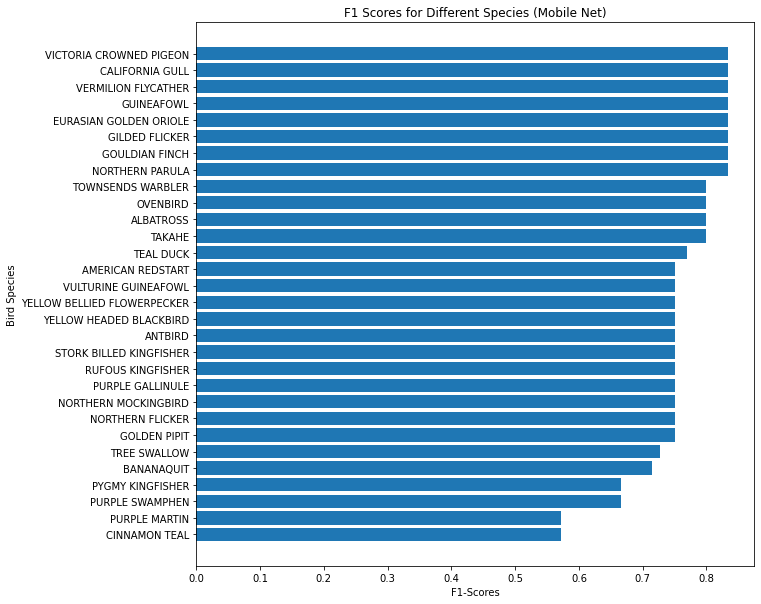

In [46]:
plot_f1_scores(report_df, model_name = "Mobile Net")

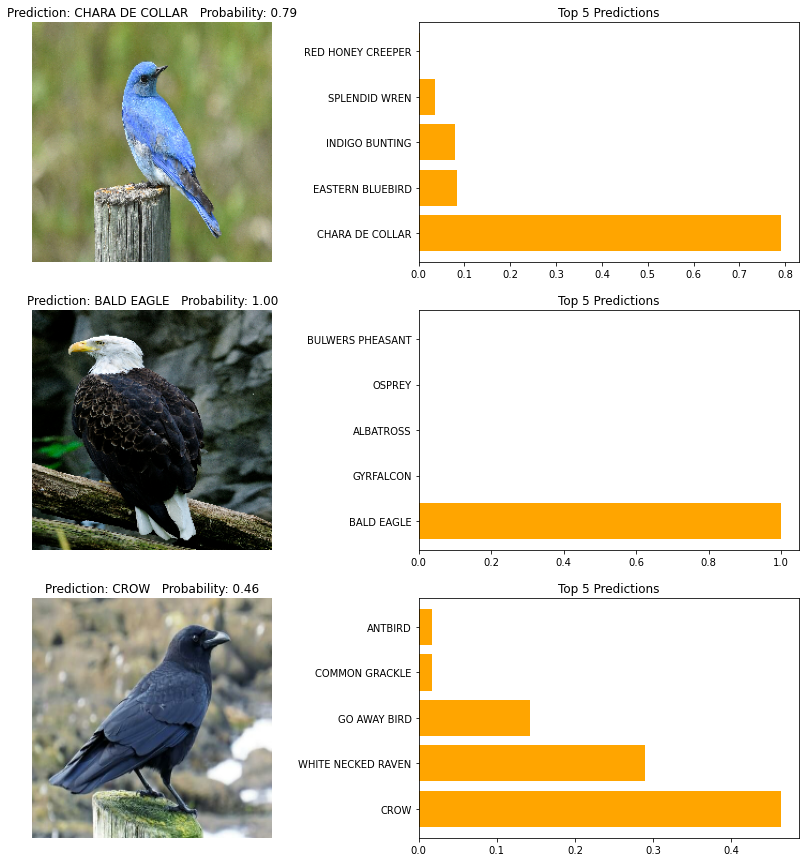

In [91]:
pred_custom_images("Example Images/", best_mobinet_model)

<h3> **Evaluating ResNet50 Model Performance ** </h3>

In [47]:
best_resnet_model = tf.keras.models.load_model("Models/ResNet50model.hdf5")

In [48]:
print_metrics(best_resnet_model)

43/43 [==============================] - 81s 2s/step - loss: 0.1212 - accuracy: 0.9658

Validation loss : 0.2080
Accuarcy on validation set is : 93.60 % 


Test loss : 0.1212
Accuarcy on test set is : 96.58 % 



In [49]:
resnet_pred = best_resnet_model.predict(test_dataset, verbose = 1)
resnet_pred = resnet_pred.argmax(axis = 1)
report = get_report(resnet_pred)

43/43 [==============================] - 81s 2s/step


In [50]:
report_df = get_f1_scores(report)
pd.concat([report_df.head(15), report_df.tail(3)],axis = 0)

f1-score
COMMON HOUSE MARTIN        0.571429
ANNAS HUMMINGBIRD          0.571429
RED WINGED BLACKBIRD       0.727273
YELLOW HEADED BLACKBIRD    0.750000
MASKED BOOBY               0.750000
BORNEAN LEAFBIRD           0.750000
SPANGLED COTINGA           0.750000
GYRFALCON                  0.769231
CAPE MAY WARBLER           0.769231
RUBY THROATED HUMMINGBIRD  0.769231
PURPLE SWAMPHEN            0.800000
RUFOUS KINGFISHER          0.800000
CANARY                     0.833333
YELLOW CACIQUE             0.833333
SAND MARTIN                0.833333
GOULDIAN FINCH             1.000000
FLAME TANAGER              1.000000
IMPERIAL SHAQ              1.000000

<h4> ResNet50 model has low prediction accuracy on: </h4>
    <li> COMMON HOUSE MARTIN </li>
    <li>ANNAS HUMMINGBIRD</li>

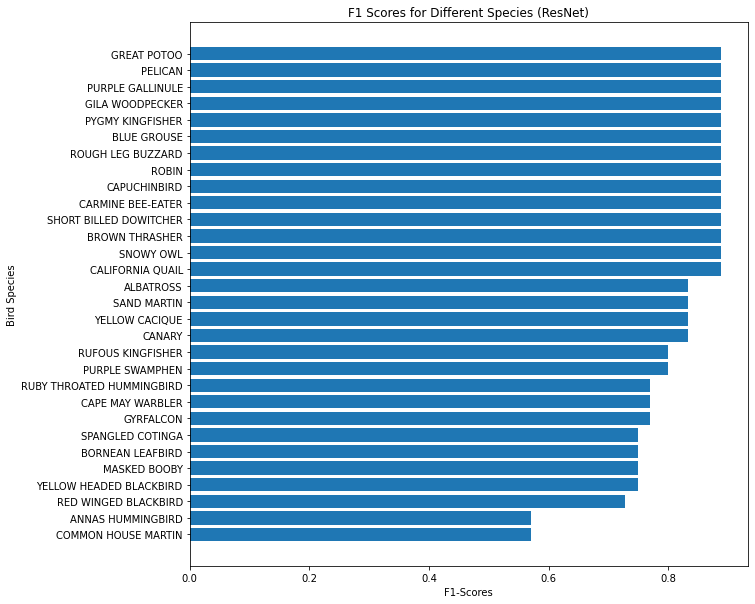

In [51]:
plot_f1_scores(report_df, model_name = "ResNet")

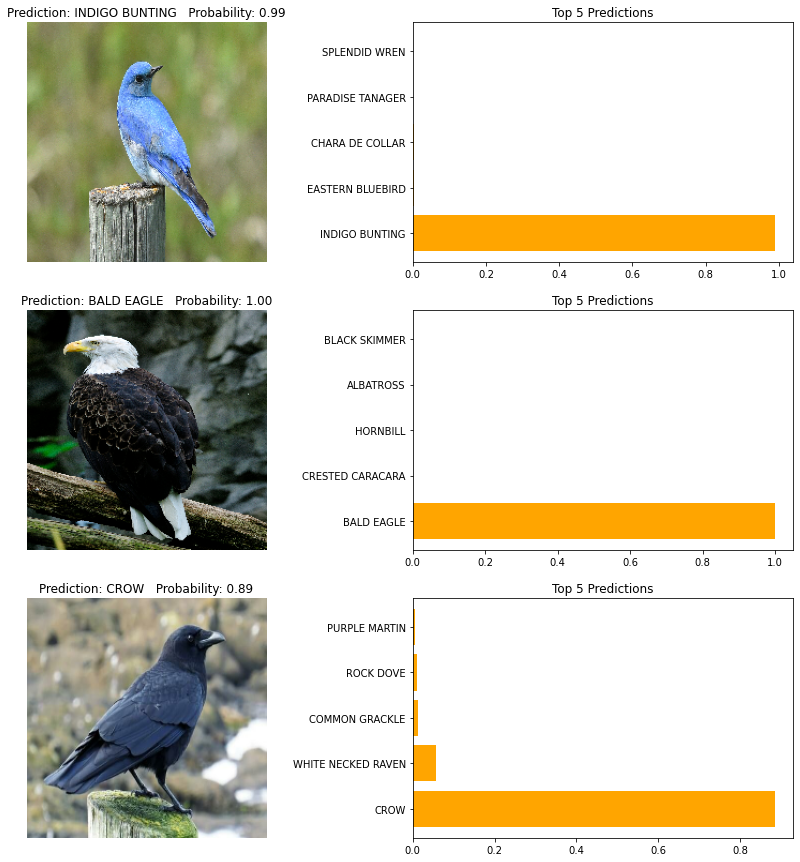

In [92]:
pred_custom_images("Example Images/", best_resnet_model)

<h3> ** Evaluating InceptionNet Model Performance ** </h3>

In [52]:
best_incep_model = tf.keras.models.load_model("Models/Inceptionmodel.hdf5")

In [53]:
print_metrics(best_incep_model)

43/43 [==============================] - 60s 1s/step - loss: 0.1334 - accuracy: 0.9520

Validation loss : 0.2019
Accuarcy on validation set is : 93.60 % 


Test loss : 0.1334
Accuarcy on test set is : 95.20 % 



In [54]:
incep_pred = best_incep_model.predict(test_dataset, verbose = 1)
incep_pred = incep_pred.argmax(axis = 1)
report = get_report(incep_pred)

43/43 [==============================] - 61s 1s/step


C:\Users\Hemanth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
report_df = get_f1_scores(report)
pd.concat([report_df.head(15), report_df.tail(3)],axis = 0)

f1-score
CINNAMON TEAL          0.000000
TOWNSENDS WARBLER      0.000000
GILDED FLICKER         0.571429
CRESTED NUTHATCH       0.571429
TAKAHE                 0.666667
BLACKBURNIAM WARBLER   0.666667
PURPLE SWAMPHEN        0.727273
BAY-BREASTED WARBLER   0.750000
GOULDIAN FINCH         0.750000
VULTURINE GUINEAFOWL   0.750000
MOURNING DOVE          0.750000
ROBIN                  0.750000
CROW                   0.750000
NORTHERN FLICKER       0.769231
BANANAQUIT             0.769231
JABIRU                 1.000000
HORNBILL               1.000000
AFRICAN CROWNED CRANE  1.000000

<h4> InceptionNet model has low prediction accuracy on: </h4>
    <li> CINNAMON TEAL </li>
    <li>TOWNSENDS WARBLER</li>
    <li>GILDED FLICKER</li>  
     <li> CRESTED NUTHATCH</li>

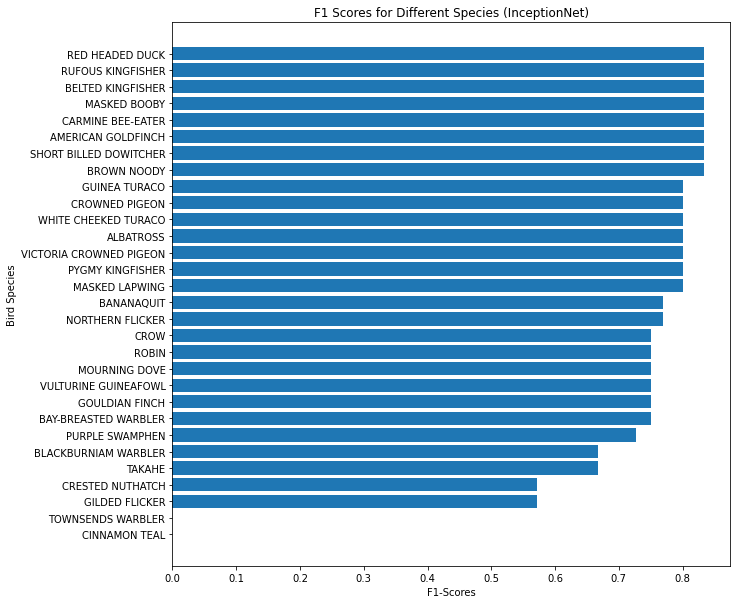

In [56]:
plot_f1_scores(report_df, model_name = "InceptionNet")

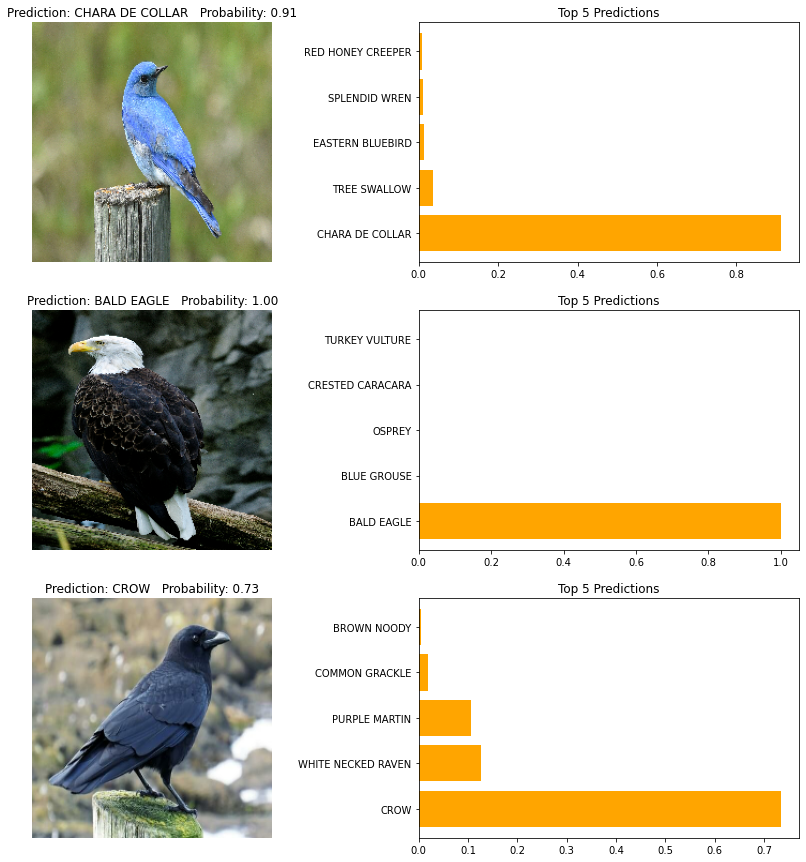

In [93]:
pred_custom_images("Example Images/", best_incep_model)